# Redes neuronales recurrentes

Motivación:

![](https://raw.githubusercontent.com/igomezv/DataScienceIntermedio/main/img/RNN.png)


Estructura:

![](https://raw.githubusercontent.com/igomezv/DataScienceIntermedio/main/img/recurrent_graph.png)
Fuente de la imagen: medium.com

Desdoblando:

![](https://raw.githubusercontent.com/igomezv/DataScienceIntermedio/main/img/unfondilg_rnn_example.png)
Fuente de la imagen: medium.com



## Red neuronal recurrente desde cero.

Fuente: https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

### Generamos una "serie de tiempo"

In [2]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)]) + np.random.rand(200)

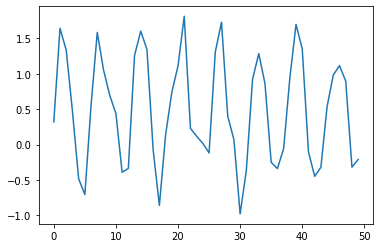

In [3]:
plt.plot(sin_wave[:50])

In [4]:
len(sin_wave), sin_wave.shape

(200, (200,))

### Guardamos algunos intervalos de tiempo X(t)

In [5]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len #150

for i in range(num_records - 50): #100
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    print("it: {} | X:{} | Y:{}".format(i, X[i], Y[i]))
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

it: 0 | X:[ 0.32131529  1.63979505  1.33229328  0.47314342 -0.48106915 -0.70525238
  0.55397132  1.58229931  1.05603825  0.69682125  0.43768178 -0.39044552
 -0.3376826   1.25809328  1.60037475  1.33973366 -0.07888037 -0.8573078
  0.13573669  0.73837944  1.11008817  1.81022973  0.22893901  0.11723899
  0.01567976 -0.11754679  1.30603241  1.72606916  0.40330645  0.06822341
 -0.97825377 -0.36129595  0.92111253  1.2835856   0.86077553 -0.25068138
 -0.3390338  -0.05816921  0.93649944  1.69573914  1.34811472 -0.10407684
 -0.44780618 -0.32160723  0.53681137  0.98265113  1.11336922  0.89528459
 -0.3183319  -0.21112586] | Y:0.06074183852687842
it: 1 | X:[ 1.63979505  1.33229328  0.47314342 -0.48106915 -0.70525238  0.55397132
  1.58229931  1.05603825  0.69682125  0.43768178 -0.39044552 -0.3376826
  1.25809328  1.60037475  1.33973366 -0.07888037 -0.8573078   0.13573669
  0.73837944  1.11008817  1.81022973  0.22893901  0.11723899  0.01567976
 -0.11754679  1.30603241  1.72606916  0.40330645  0.0682

In [6]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

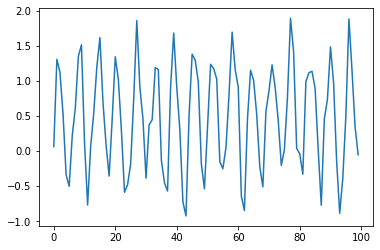

In [7]:
plt.plot(Y)

### Creamos un conjunto de validación

In [8]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    print("it: {} | X:{} | Y:{}".format(i, X_val[i-100], Y_val[i-100]))
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

it: 100 | X:[ 0.33606997  1.2330111   1.17311683  1.02161868 -0.15448372 -0.25593149
  0.04613757  0.80219319  1.69201484  1.15730408  0.90826601 -0.64613044
 -0.85218717  0.453278    1.14910339  1.00415419  0.52002176 -0.22541873
 -0.51397996  0.56179369  0.85569029  1.22614147  0.90434828  0.43268354
 -0.20850916  0.01439361  0.75852857  1.89024344  1.41129803  0.03476031
 -0.04478477 -0.33414346  0.98782512  1.11442927  1.13313934  0.88760064
  0.02023292 -0.77626552  0.45578215  0.72903191  1.48197458  0.97649782
 -0.15224444 -0.89139517 -0.39419557  0.49936673  1.87993477  1.14594972
  0.34025708 -0.05719903] | Y:-0.5093053620244941
it: 101 | X:[ 1.2330111   1.17311683  1.02161868 -0.15448372 -0.25593149  0.04613757
  0.80219319  1.69201484  1.15730408  0.90826601 -0.64613044 -0.85218717
  0.453278    1.14910339  1.00415419  0.52002176 -0.22541873 -0.51397996
  0.56179369  0.85569029  1.22614147  0.90434828  0.43268354 -0.20850916
  0.01439361  0.75852857  1.89024344  1.41129803  

## Arquitectura de la RNN

In [9]:
learning_rate = 0.0001    
nepoch = 5              
T = 50                   # largo de la secuencia
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

### Matrices de Pesos:

 - U es la matriz de pesos para los pesos entre la entrada y las capas ocultas.
 - V es la matriz de pesos para los pesos entre las capas ocultas y las de salida.
 - W es la matriz de pesos para los pesos compartidos en la capa oculta, la capa recurrente propia de las RNNs.

In [10]:
U = np.random.uniform(0, 1, (hidden_dim, T))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))

### Función de activación:

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Entrenamiento
```
for epocas 
    for secuence in Y
        for element in secuence
```

In [12]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    
    # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    
    # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[134911.88328656]] , Val Loss:  [[67474.94444269]]
Epoch:  2 , Loss:  [[87972.46886359]] , Val Loss:  [[44001.86638182]]
Epoch:  3 , Loss:  [[51033.05444045]] , Val Loss:  [[25528.78832087]]
Epoch:  4 , Loss:  [[24093.63819302]] , Val Loss:  [[12055.70934713]]
Epoch:  5 , Loss:  [[7140.80443572]] , Val Loss:  [[3575.91612167]]


In [13]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

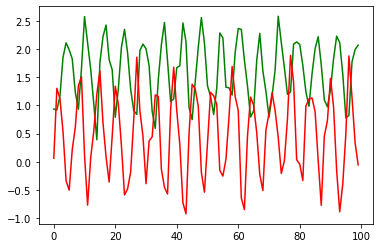

In [14]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

### Ahora en el conjunto de validación

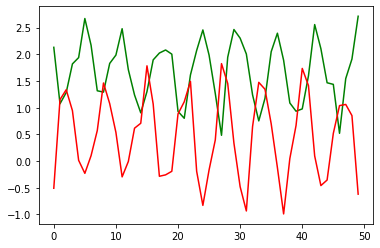

In [15]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y_val[:, 0], preds[:, 0, 0])

2.9617540243012934

### Red recurrente en Keras

Fuente: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

![](https://raw.githubusercontent.com/igomezv/DataScienceIntermedio/main/img/lstm.png)
Fuente de la imagen: medium.com


In [17]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

2022-11-14 13:37:56.472767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 13:37:56.574453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-14 13:37:56.574471: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-14 13:37:56.595752: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 13:37:57.115281: W tensorflow/stream_executor/platform/de

In [18]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


In [19]:
# First, we get the data
dataset = pd.read_csv('https://raw.githubusercontent.com/igomezv/DataScienceIntermedio/main/datasets/IBM_2006-01-01_to_2018-01-01.xls', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [20]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

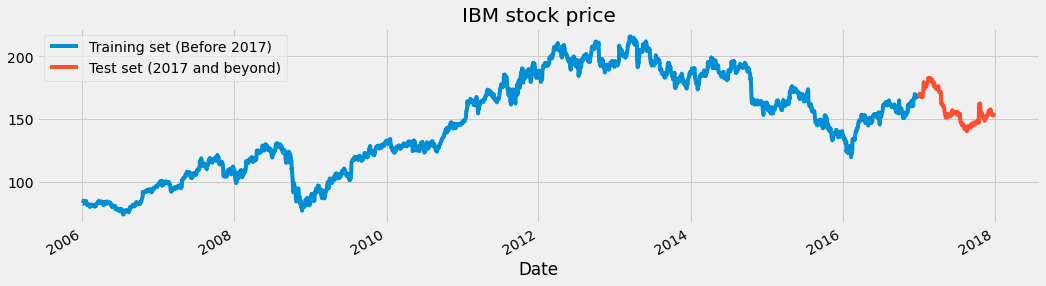

In [21]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()



In [22]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [23]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)



In [24]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [25]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=10,batch_size=32)

2022-11-14 13:37:58.108266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-14 13:37:58.108292: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-14 13:37:58.108315: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: isidro-pc
2022-11-14 13:37:58.108321: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: isidro-pc
2022-11-14 13:37:58.108402: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-11-14 13:37:58.108429: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.85.2
2022-11-14 13:37:58.108590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor

Epoch 1/10
85/85 [==============================] - 9s 62ms/step - loss: 0.0225
Epoch 2/10
85/85 [==============================] - 5s 61ms/step - loss: 0.0103
Epoch 3/10
85/85 [==============================] - 5s 61ms/step - loss: 0.0078
Epoch 4/10
85/85 [==============================] - 5s 62ms/step - loss: 0.0070
Epoch 5/10
85/85 [==============================] - 5s 62ms/step - loss: 0.0063
Epoch 6/10
85/85 [==============================] - 5s 63ms/step - loss: 0.0052
Epoch 7/10
85/85 [==============================] - 5s 63ms/step - loss: 0.0048
Epoch 8/10
85/85 [==============================] - 5s 62ms/step - loss: 0.0045
Epoch 9/10
85/85 [==============================] - 5s 62ms/step - loss: 0.0042
Epoch 10/10
85/85 [==============================] - 5s 63ms/step - loss: 0.0042


In [26]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [27]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 19ms/step


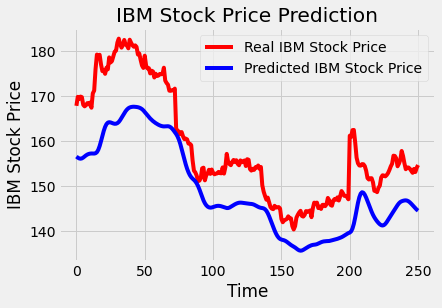

In [28]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [29]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 10.011724887486643.


### Ejercicio: ¿Cómo podemos mejorar el entrenamiento?